# Unit 3: Demographic Recommendations

In this section we leave the boring field of unpersonalized content and do our first steps for more personalization. But, before tailoring content to individuals we first tailor content to groups of individuals that by some criteria seem to be similar and therefore - assumed to - consume similar content.

We distinguish individuals into groups by using demographic information we have on these individuals. This can be any of
* age
* gender
* citizenship
* income
* etc.

In [1]:
import itertools
from typing import List

import numpy as np
import pandas as pd

In [2]:
from recsys_training.data import Dataset
from recsys_training.evaluation import get_relevant_items

In [3]:
ml100k_ratings_filepath = '../data/raw/ml-100k/u.data'
ml100k_user_filepath = '../data/raw/ml-100k/u.user'

## Load Data

In [4]:
data = Dataset(ml100k_ratings_filepath)
data.rating_split(seed=42)
user_ratings = data.get_user_ratings()

MovieLens also provides some demographic data on users along with the datasets. We will user _age_ and _gender_ in this tutorial to create different groups.

In [5]:
users = pd.read_csv(ml100k_user_filepath, sep='|', header=None,
                    names=['user', 'age', 'gender', 'occupation', 'zip'])

## Explore Data

In [6]:
users.head()

,user,age,gender,occupation,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


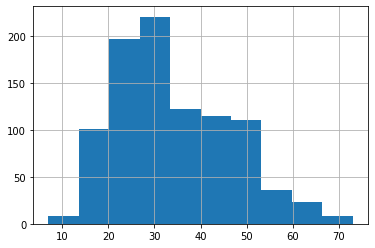

In [7]:
users.age.hist()

Let's define 2 x 6 user groups by splitting by gender and age class (see advice [here](https://support.google.com/analytics/answer/2799357?hl=de))

In [8]:
gender_groups = ['M', 'F']
age_groups = [(18, 24),
              (25, 34),
              (35, 44),
              (45, 54),
              (55, 65),
              (65, 73)]

user_groups = list(itertools.product(gender_groups, age_groups))
user_group_indices = range(len(user_groups))
user_groups = dict(zip(user_group_indices, user_groups))

In [9]:
user_groups

{0: ('M', (18, 24)),
 1: ('M', (25, 34)),
 2: ('M', (35, 44)),
 3: ('M', (45, 54)),
 4: ('M', (55, 65)),
 5: ('M', (65, 73)),
 6: ('F', (18, 24)),
 7: ('F', (25, 34)),
 8: ('F', (35, 44)),
 9: ('F', (45, 54)),
 10: ('F', (55, 65)),
 11: ('F', (65, 73))}

In [10]:
def assign_group(row, age_groups=age_groups):
    for age_group in age_groups:
        if row['age'] >= age_group[0] and row['age'] <= age_group[1]:
            break
    return (row['gender'], age_group)

In [11]:
users['group'] = users.apply(lambda row: assign_group(row, age_groups), axis=1)

In [12]:
users['group'] = users['group'].map(lambda val: list(user_groups.values()).index(val))

In [13]:
users['group'].value_counts()

1     231
0     143
2     125
3      94
7      79
8      69
6      55
9      48
4      46
5      31
11     14
10      8
Name: group, dtype: int64

**Task**: For each group we use popularity recommendations based on the groups historical viewing popularity. Infer the `group_popularities` as a mapping from group index to the item ordering array.

In [14]:
group_popularities = dict.fromkeys(user_group_indices)

In [15]:
for group_idx in user_group_indices:
    group_members = users[users['group'] == group_idx]['user'].values
    group_ratings = data.train_ratings[data.train_ratings['user'].isin(group_members)]
    group_popularities[group_idx] = group_ratings.item.value_counts().index.values

In [16]:
group_popularities

{0: array([ 288,  181,  258, ..., 1323, 1427, 1547]),
 1: array([  50,    1,  181, ..., 1318, 1107, 1451]),
 2: array([  50,  181,  127, ..., 1067, 1075, 1427]),
 3: array([ 286,  100,  300, ..., 1560, 1608, 1615]),
 4: array([ 286,  100,  300,  269,   50,  302,  307,  294,  322,  657,  313,
         289,  127,  327,  515,  483,  194,  328,  245,  181,  321,   89,
         237,  268,  678,  474,  511,  301,  748,  323,  285,   98,   56,
         315,  174,  427,  435,  510,  205,  654,  234,  605,  161,  210,
         288,  303,  204,  258,  196,  191,  272,  182,  153,  603,  527,
           9,  134,   25,   69,  479,  690,  661,  507,   79,  197,  484,
          70,  471,  750,  193,  195,  520,  124,  187,  185,  332,   96,
         318,  340,  179,  135,  275,  257,  259,  480,  488,  242,  482,
         357,  519,  311,  310,  705,  423,  319,  326,  526,  333,  316,
         485,  117,  215,    8,   22,  131,   82,  211,  213,  276,  183,
         292,  312,  429,  648,   97,  18

**Task:** Adapt the $MAP@10$ recommendation method from the popularity recommendation notebook accordingly and compute the $MAP@10$ for demographic recommendations.

In [17]:
user_group_map = dict(zip(users['user'].values,users['group'].values))

In [18]:
def get_recommendations(user: int,
                        user_ratings: dict,
                        user_group_map: dict,
                        group_popularities: dict,
                        N: int) -> List[int]:
    known_positives = list(user_ratings[user].keys())
    user_group_idx = user_group_map[user]
    recommendations = np.setdiff1d(group_popularities[user_group_idx],
                                   known_positives)[:N]
    
    return recommendations

## Evaluation Evaluating the Relevance of Recommendations

In [21]:
relevant_items = get_relevant_items(data.test_ratings)

Computing $MAP@10$

In [22]:
N = 10

In [23]:
users = relevant_items.keys()
prec_at_N = dict.fromkeys(users)

for user in users:
    recommendations = get_recommendations(user,
                                          user_ratings,
                                          user_group_map,
                                          group_popularities,
                                          N=N)
    hits = np.intersect1d(recommendations,
                          relevant_items[user])
    prec_at_N[user] = len(hits)/N

In [24]:
np.mean(list(prec_at_N.values()))

0.06404255319148937

What is the $MAP@10$ for ea. specific group?

In [25]:
group_maps = dict.fromkeys(user_group_indices, list())
for user in users:
    group_maps[user_group_map[user]].append(prec_at_N[user])
for group in user_group_indices:
    group_maps[group] = np.mean(group_maps[group])

In [26]:
group_maps

{0: 0.06404255319148937,
 1: 0.06404255319148937,
 2: 0.06404255319148937,
 3: 0.06404255319148937,
 4: 0.06404255319148937,
 5: 0.06404255319148937,
 6: 0.06404255319148937,
 7: 0.06404255319148937,
 8: 0.06404255319148937,
 9: 0.06404255319148937,
 10: 0.06404255319148937,
 11: 0.06404255319148937}